# How to run clay over custom AOIs

This script shows in a few simple steps how the clay model can be run for custom AOIs and over custom date ranges.

## Download and open global list of MGRS tiles

In [1]:
import os
from pathlib import Path

# The repo home is our working directory.
wd = Path.cwd().parent
os.chdir(wd)
# Ensure data directories exist
Path("data/mgrs").mkdir(exist_ok=True)
Path("data/chips").mkdir(exist_ok=True)
Path("data/checkpoints").mkdir(exist_ok=True)
Path("data/embeddings").mkdir(exist_ok=True)

In [2]:
import geopandas as gpd

! wget https://clay-mgrs-samples.s3.amazonaws.com/mgrs_full.fgb -O data/mgrs/mgrs_full.fgb

--2024-01-12 16:21:52--  https://clay-mgrs-samples.s3.amazonaws.com/mgrs_full.fgb
Resolving clay-mgrs-samples.s3.amazonaws.com (clay-mgrs-samples.s3.amazonaws.com)... 3.5.28.121, 52.217.202.65, 54.231.230.89, ...
Connecting to clay-mgrs-samples.s3.amazonaws.com (clay-mgrs-samples.s3.amazonaws.com)|3.5.28.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13787464 (13M) [binary/octet-stream]
Saving to: ‘data/mgrs/mgrs_full.fgb’

data/mgrs/mgrs_full 100%[===================>]  13.15M  3.55MB/s    in 4.3s    

2024-01-12 16:21:57 (3.04 MB/s) - ‘data/mgrs/mgrs_full.fgb’ saved [13787464/13787464]



In [3]:
mgrs = gpd.read_file("data/mgrs/mgrs_full.fgb")
mgrs

,Name,geometry
0,59CNK,"MULTIPOLYGON (((170.99885 -81.06088, 177.30316..."
1,59CNJ,"MULTIPOLYGON (((170.99872 -81.95638, 177.99281..."
2,58CEN,"MULTIPOLYGON (((164.99856 -82.85238, 172.85358..."
3,58CEP,"MULTIPOLYGON (((164.99872 -81.95638, 171.99281..."
4,60CVQ,"MULTIPOLYGON (((171.25220 -81.01644, 177.56261..."
...,...,...
56681,02CMR,"MULTIPOLYGON (((-176.23170 -80.12446, -170.488..."
56682,02CMQ,"MULTIPOLYGON (((-176.74780 -81.01644, -170.437..."
56683,01CEK,"MULTIPOLYGON (((-177.00115 -81.06088, -170.696..."
56684,01CEJ,"MULTIPOLYGON (((-177.00128 -81.95638, -170.007..."


In [4]:
mgrs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Create a Geopandas dataframe with AOI

This example uses a string with a single polygon over the area around Puri, India.

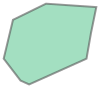

In [5]:
aoi_src = """{
    "type": "FeatureCollection",
    "name": "puri",
    "crs": {
        "type": "name",
        "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" }
    },
    "features": [
        {
            "type": "Feature",
            "properties": {
                "Region": "Puri"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [ [ [ 85.050328768992927, 19.494998302498729 ], [ 85.169749958884921, 19.441346370958311 ], [ 85.968028516820738, 19.799945705366934 ], [ 86.029742823006544, 20.15322442052609 ], [ 86.104280881127053, 20.516965603502392 ], [ 85.404584916189307, 20.564248936237991 ], [ 84.945334300027469, 20.339711117597215 ], [ 84.816295296184407, 19.799945705366934 ], [ 85.050328768992927, 19.494998302498729 ] ] ]
            }
        }
    ]
}"""
aoi = gpd.read_file(aoi_src, driver="GeoJSON")
aoi.geometry[0]

## Intersect the AOI with the MGRS tile layer

This will select the MGRS tiles that intersect with your AOI. The processing will then happen for each of the MGRS tiles. This will most likely provide slightly more data than the AOI itself, as the whole tile data will downloaded for each matched MGRS tile.

Store the intersected tiles in a file, it will be used by the `datacube.py` script.

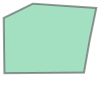

In [6]:
mgrs_aoi = mgrs.overlay(aoi)
# Rename the name column to use lowercase letters for the datacube script to
# pick upthe MGRS tile name.
mgrs_aoi = mgrs_aoi.rename(columns={"Name": "name"})
mgrs_aoi.geometry[2]

In [7]:
mgrs_aoi.to_file("data/mgrs/mgrs_aoi.fgb")
mgrs_aoi

,name,Region,geometry
0,44QRH,Puri,"POLYGON ((84.90927 19.76528, 84.84192 19.76656..."
1,45QTC,Puri,"POLYGON ((85.18408 19.79882, 84.82081 19.79406..."
2,45QUC,Puri,"POLYGON ((85.09075 19.79784, 85.08326 20.40715..."
3,45QVC,Puri,"POLYGON ((86.04044 20.52128, 86.10428 20.51697..."
4,45QTB,Puri,"POLYGON ((85.18307 19.88715, 85.18791 19.44951..."
5,44QRG,Puri,"POLYGON ((84.91143 19.85345, 84.90733 19.68132..."
6,45QUB,Puri,"POLYGON ((85.98431 19.89314, 85.96803 19.79995..."


## Use the datacube.py script to download imagery

Each run of th datacube script will take an index as input, which is the index of the geometry within the input file. This is why we need to download the data in a loop.

A list of date ranges can be specified. The script will look for the least cloudy Sentinel-2 scene for each date range, and match Sentinel-1 dates near the identified Sentinel-2 dates.

The output folder can be specified as a local folder, or a bucket can be specified to upload the data to S3.

In [8]:
# Print the help of the script to get a sense of the input parameters.
! python scripts/datacube.py --help

Usage: datacube.py [OPTIONS]

Options:
  --sample TEXT      Location of MGRS tile sample
  --index INTEGER    Index of MGRS tile from sample file that should be
                     processed
  --bucket TEXT      Specify the bucket for where to write the data.
  --subset TEXT      For debugging, subset x and y to this pixel window as a
                     comma separated string of 4 integers.
  --localpath TEXT   If specified, this path will be used to write the tiles
                     locally. Otherwise a temp dir will be used.
  --dateranges TEXT  Comma separated list of date ranges, each provided as yy-
                     mm-dd/yy-mm-dd.
  --help             Show this message and exit.


In the example below, we limit data volume to a pixel window of 1024x1024 pixels to speed up processing. With the subsetting, this should provide up to 4 image "chips" per MGRS tile and date range, depending on data availability. Remove the subset argument for a real use case, where all the data should be downloaded.

In [9]:
for index, row in mgrs_aoi.iterrows():
    print(index, row)
    ! python scripts/datacube.py --sample data/mgrs/mgrs_aoi.fgb --subset 1500,1500,2524,2524 --localpath data/chips  --index {index} --dateranges 2020-01-01/2020-04-01,2021-06-01/2021-09-15

0 name                                                    44QRH
Region                                                   Puri
geometry    POLYGON ((84.9092728354 19.7652787938, 84.8419...
Name: 0, dtype: object
Starting algorithm for MGRS tile 45QUB with index 0
Processing data for date range 2020-01-01/2020-04-01
Found 14 Sentinel-2 items
EPSG code based on Sentinel-2 item:  32645
Searching S1 in date range 2020-02-09/2020-02-15
Found 1 Sentinel-1 items
Most overlapped orbit:  descending
Found 2 DEM items
/home/tam/apps/miniforge3/envs/claymodel/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/home/tam/apps/miniforge3/envs/claymodel/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWar


KeyboardInterrupt



## Create the embeddings for each training chip

The checkpoints can be downloaded from huggingface.

In [10]:
! wget https://huggingface.co/made-with-clay/Clay/resolve/main/Clay_v0.1_epoch-24_val-loss-0.46.ckpt?download=true -O data/checkpoints/Clay_v0.1_epoch-24_val-loss-0.46.ckpt

--2024-01-12 16:28:56--  https://huggingface.co/made-with-clay/Clay/resolve/main/Clay_v0.1_epoch-24_val-loss-0.46.ckpt?download=true
Resolving huggingface.co (huggingface.co)... 2600:9000:2660:c400:17:b174:6d00:93a1, 2600:9000:2660:6400:17:b174:6d00:93a1, 2600:9000:2660:de00:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:2660:c400:17:b174:6d00:93a1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/9e/5f/9e5f70717de49e5e8fb94cc66c7c40e24e6800ae6dbf377099154c19eafdc5f6/b5efd4073b0602e5625cce629756abfd0f10fcb6fdfa9aee02088ea735d253cd?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27Clay_v0.1_epoch-24_val-loss-0.46.ckpt%3B+filename%3D%22Clay_v0.1_epoch-24_val-loss-0.46.ckpt%22%3B&Expires=1705336139&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNTMzNjEzOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL

After downloading the model weights, embeddings can be created with just one command.

In [11]:
! wandb disabled
! python trainer.py predict --ckpt_path=data/checkpoints/Clay_v0.1_epoch-24_val-loss-0.46.ckpt \
                            --trainer.precision=16-mixed \
                            --data.data_dir=/home/tam/Desktop/aoitiles \
                            --data.batch_size=2 \
                            --data.num_workers=8

W&B disabled.
Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Seed set to 42
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

Total number of chips: 28
Restoring states from the checkpoint path at data/checkpoints/Clay_v0.1_epoch-24_val-loss-0.46.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at data/checkpoints/Clay_v0.1_epoch-24_val-loss-0.46.ckpt
Predicting DataLoader 0: 100%|██████████████████| 14/14 [00:02<00:00,  6.89it/s]Saved 7 rows of embeddings of shape (768,) to /home/tam/D